Source Code: https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

Adapted by Maëlys Boudier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

2024-05-09 13:18:25.465723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


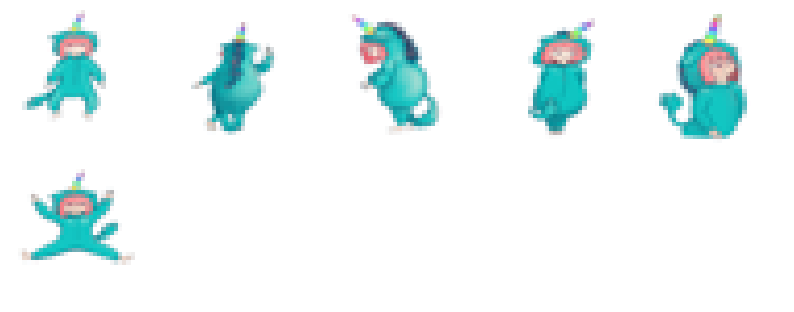

In [2]:
# Load your image dataset and resize each image
# imgs = [np.array(Image.open(path).resize((512, 512))) for path in glob.glob("/content/drive/MyDrive/Thesis/personnage/*.jpg")]
imgs = [np.array(Image.open(path).resize((32,32))) for path in glob.glob("/content/drive/MyDrive/Thesis/personnage/*.jpg")]
num_imgs_to_preview = min(6, len(imgs))

# # Display the images in a grid
# def image_grid(images, rows, cols):
#     plt.figure(figsize=(10, 10))
#     for i in range(len(images)):
#         plt.subplot(rows, cols, i+1)
#         plt.imshow(images[i])
#         plt.axis('off')
#     plt.show()

# image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

# Preprocess your image data
X_train = np.array(imgs) / 127.5 - 1.0

# Function to normalize images
def cvtImg(img):
    img = img - img.min()
    img = img / img.max()
    return img.astype(np.float32)

# Show examples of your dataset
def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(x))):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)


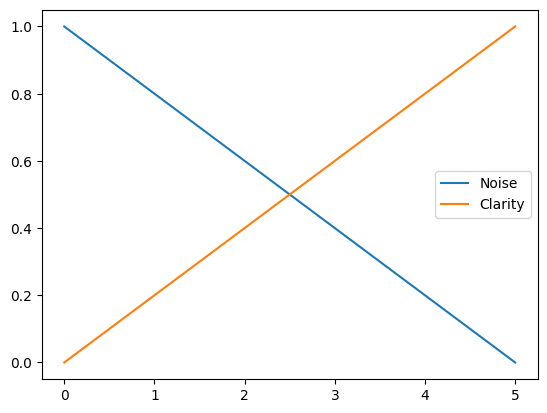

In [3]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 2  # for training batch size
timesteps = 5    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

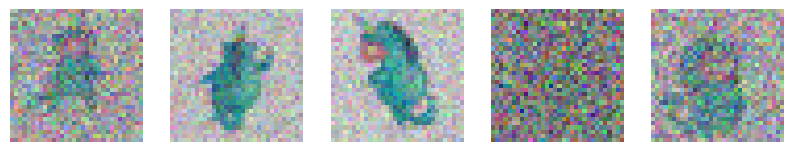

In [4]:

def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((5,), timesteps - 1) # if you want see clarity
# t = np.full((5,), 0)             # if you want see noisy
t = generate_ts(5)             # random for training data
a, b = forward_noise(X_train[:5], t)
show_examples(a)

In [5]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter

    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)

    return x_out


In [6]:
# def make_model():
#     x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

#     x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
#     x_ts = layers.Dense(192)(x_ts)
#     x_ts = layers.LayerNormalization()(x_ts)
#     x_ts = layers.Activation('relu')(x_ts)

#     # ----- left ( down ) -----
#     x = x32 = block(x, x_ts)
#     x = layers.MaxPool2D(2)(x)

#     x = x16 = block(x, x_ts)
#     x = layers.MaxPool2D(2)(x)

#     x = x8 = block(x, x_ts)
#     x = layers.MaxPool2D(2)(x)

#     x = x4 = block(x, x_ts)

#     # ----- MLP -----
#     x = layers.Flatten()(x)
#     x = layers.Concatenate()([x, x_ts])
#     x = layers.Dense(128)(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.Activation('relu')(x)

#     x = layers.Dense(4 * 4 * 32)(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Reshape((4, 4, 32))(x)

#     # ----- right ( up ) -----
#     x = layers.Concatenate()([x, x4])
#     x = block(x, x_ts)
#     x = layers.UpSampling2D(2)(x)

#     x = layers.Concatenate()([x, x8])
#     x = block(x, x_ts)
#     x = layers.UpSampling2D(2)(x)

#     x = layers.Concatenate()([x, x16])
#     x = block(x, x_ts)
#     x = layers.UpSampling2D(2)(x)

#     x = layers.Concatenate()([x, x32])
#     x = block(x, x_ts)

#     # ----- output -----
#     x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
#     model = tf.keras.models.Model([x_input, x_ts_input], x)
#     return model

# model = make_model()
# # model.summary()

In [15]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)

    x = x4 = block(x, x_ts)

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    print("Shape of x before concatenating with x4:", x.shape)
    print("Shape of x4:", x4.shape)
    x = layers.Concatenate()([x, x4])
    print("Shape after concatenation:", x.shape)
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)

    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)

model = make_model()
# model.summary()

Shape of x before concatenating with x4: (None, 4, 4, 32)
Shape of x4: (None, 4, 4, 128)
Shape after concatenation: (None, 4, 4, 160)


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)


  0%|          | 0/5 [00:00<?, ?it/s]

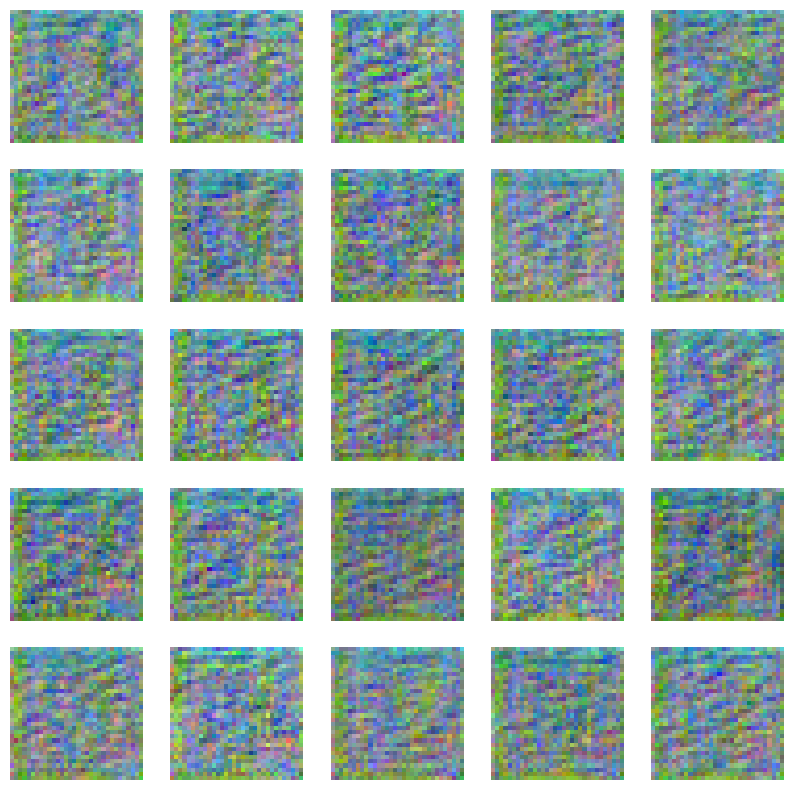

In [8]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()


  0%|          | 0/5 [00:00<?, ?it/s]

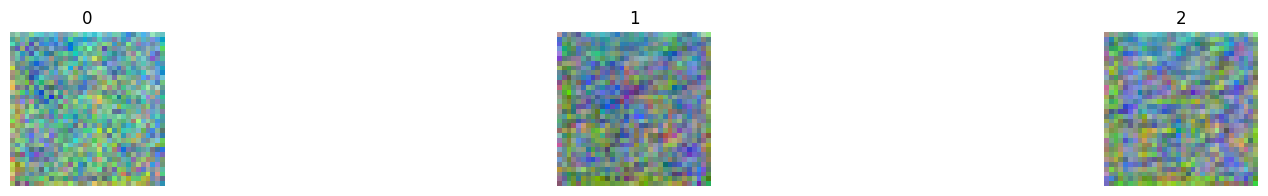

In [9]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()


In [10]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss


In [11]:
def train(R=4):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

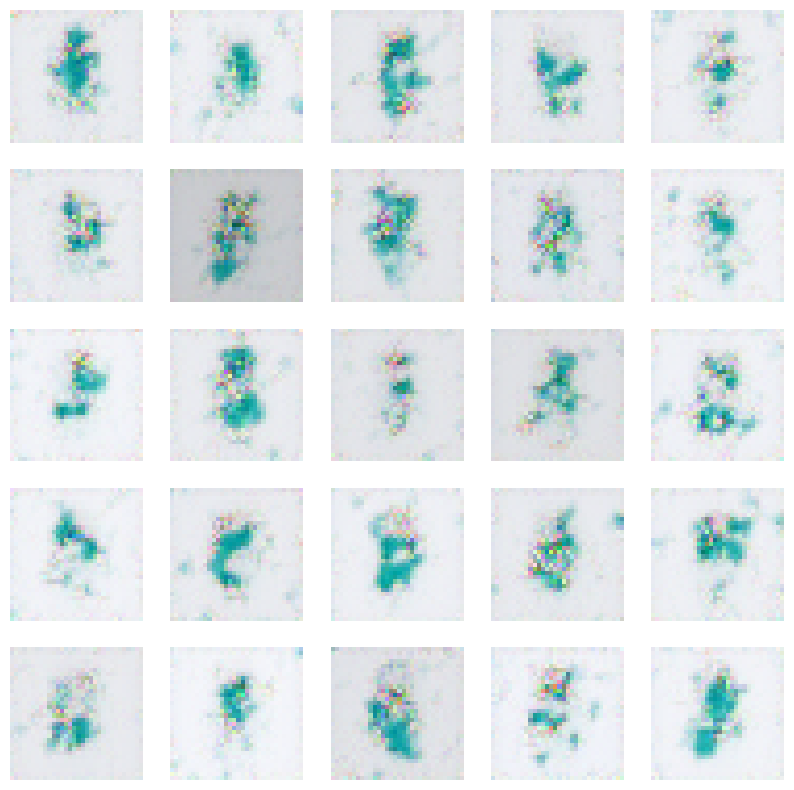

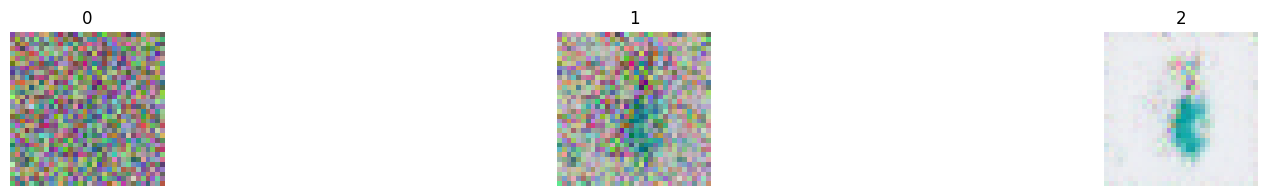

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
for _ in range(1):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()
